In [1]:
import sys
sys.path.insert(0, r'C:\Users\user\Desktop\py') # add path of module
from shfqc import SHFQC
from zhinst.toolkit import Session
import numpy as np
from matplotlib import pyplot as plt
from filekit import *

In [2]:
# connect to SHFQC
session = Session("localhost")
device = session.connect_device("DEV12594")
shfqc = SHFQC(device, session)

In [4]:
# choose a data base to store measurement data
database_folder = get_folderpath(
    title='choose a database', start_folder=r'D:\experiment_data'
)
print(f'`{database_folder}` is now in use as database.')

`D:/experiment_data/CLS` is now in use as database.


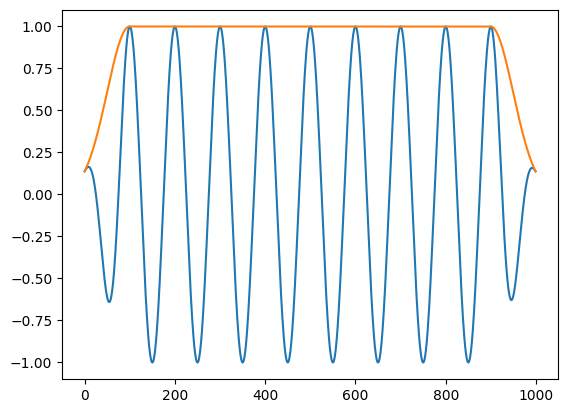

In [ ]:
# make a waveform for testing
from scipy.signal.windows import gaussian

SAMPLING_RATE = 2e9
rise_fall_time = 50e-9
pulse_duration = 500e-9

rise_fall_len = int(rise_fall_time * SAMPLING_RATE)
pulse_len = int(pulse_duration * SAMPLING_RATE)
std_dev = rise_fall_len // 2

gauss = gaussian(2 * rise_fall_len, std_dev)
flat_top_gaussian = np.ones(pulse_len)
flat_top_gaussian[0:rise_fall_len] = gauss[0:rise_fall_len]
flat_top_gaussian[-rise_fall_len:] = gauss[-rise_fall_len:]

# carrier, within -100~+100 MHz
f_carrier = 0.020e+9 # carrier frequency
t = np.arange(len(flat_top_gaussian)) * 1/SAMPLING_RATE
carrier = np.exp(1j* 2*np.pi* f_carrier * t)
complex_waveform = flat_top_gaussian * carrier
plt.plot(np.real(complex_waveform))
plt.plot(np.abs(complex_waveform))
plt.show()

In [ ]:
# upload waveform, in numpy array
shfqc.qa_assign_single_complex_waveform(complex_waveform)

In [5]:
# set config of scope, duration and delay is time, in second
shfqc.qa_set_scope_config(
    window_duration=700e-9,
    n_avg=20,
    trigger_delay=100e-9
)

In [6]:
# turn on-off output and their value
input_range = -0 # dbm
output_range = -5 # dbm
shfqc.qa_input_range(input_range) # dbm
shfqc.qa_output_range(output_range) # dbm
shfqc.qa_input(1)
shfqc.qa_output(1)

In [ ]:
# measured time domain signal
f_center = 4.2e+9
shfqc.qa_center_freq(f_center) # the output freq will then be center + carrirer 

digitized_signal = shfqc.qa_measure_signal(
    n_mea=20, # should be the same as n_avg in the scope
    readout_duration=700e-9 # should be the same as window_duration in the scope
)

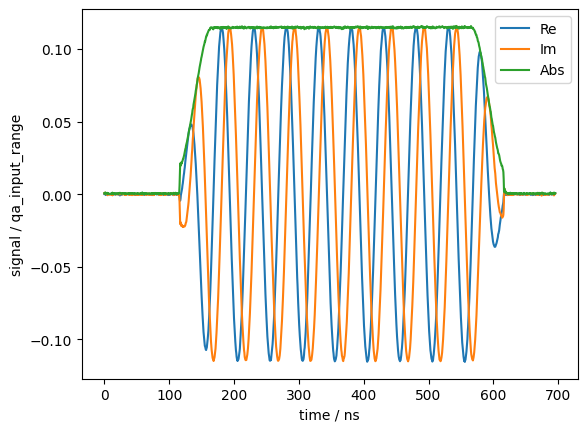

In [9]:
# plot the result, user can scale x and y, by your knowlege
t = np.arange(len(digitized_signal)) * 1/SAMPLING_RATE
plt.plot(t*1e+9, np.real(digitized_signal), label='Re')
plt.plot(t*1e+9, np.imag(digitized_signal), label='Im')
plt.plot(t*1e+9, np.abs(digitized_signal), label='Abs')
plt.xlabel('time / ns')
plt.ylabel('signal / qa_input_range')
plt.legend()
plt.show()

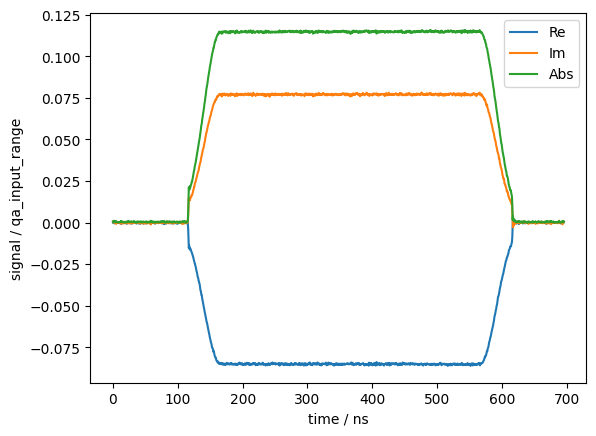

In [ ]:
# IQ demod
t_de = np.arange(len(digitized_signal)) * 1/SAMPLING_RATE
f_de = -0.020e+9 # demod frequency
weight = np.exp(1j* 2*np.pi* f_de * t_de)
iqmod = digitized_signal * weight

# plot
t = np.arange(len(iqmod)) * 1/SAMPLING_RATE
plt.plot(t*1e+9, np.real(iqmod), label='Re')
plt.plot(t*1e+9, np.imag(iqmod), label='Im')
plt.plot(t*1e+9, np.abs(iqmod), label='Abs')
plt.xlabel('time / ns')
plt.ylabel('signal / qa_input_range')
plt.legend()
plt.show()

In [ ]:
# save measurement data into csv file
save_name = 'time_domain_testing'
comments = [
    f'input: {input_range} dbm', 
    f'output: {output_range} dbm',
    f'carrier_f : {f_center + f_carrier}Hz',
]

datafolder_today = get_datafolder_today(database_folder)
save_to_csv(
    filename=datafolder_today + f'\\{save_name}.csv',
    title_array = ['time', 'normalized_signal', 'comments'],
    data_array=[t, digitized_signal, comments]
)

Run a sweep with 401 frequency points in the range of [-200.0, 400.0] MHz + 4.4 GHz. 
Mapping is linear. 
Integration time = 0.0001 sec. 
Measures 20 times per frequency point. 
Averaging mode is sequential.
Trigger source is set to None, which means the sequencer defines the repetition rate.
Measurement (8020/8020) at 400.000MHz.                     


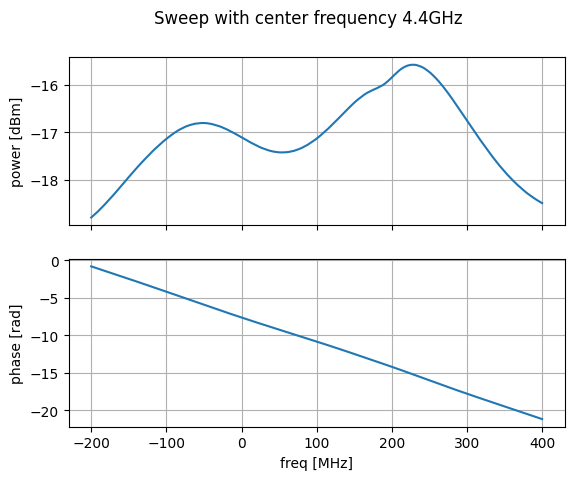

In [19]:
# measure spectrum
center_f = 4.4e+9
lo_start_f = -200e+6
lo_stop_f = +400e+6
lo_n_pts = 401
spec_input_range = -15 # dbm
spec_output_range = -15 # dbm
spec_gain = 0.7
freq = np.linspace(lo_start_f, lo_stop_f, lo_n_pts) + center_f

spectrum_data = shfqc.qa_measure_spectrum(
    center_f=center_f, lo_start_f=lo_start_f, lo_stop_f=lo_stop_f, 
    lo_n_pts=lo_n_pts, n_avg=20, 
    gain=spec_gain, input_range=spec_input_range, output_range=spec_output_range,
    plot=True
)

In [12]:
# save measurement data into csv file
save_name = 'specturm_data_testing'
comments = [
    f'input: {spec_input_range} dbm', 
    f'output: {spec_output_range} dbm',
    f'gain: {spec_gain}'
]

datafolder_today = get_datafolder_today(database_folder)
save_to_csv(
    filename=datafolder_today + f'\\{save_name}.csv',
    title_array = ['freq', 'normalized_signal', 'comments'],
    data_array=[freq, spectrum_data, comments]
)

In [13]:
# turn off input/output
shfqc.qa_input(0)
shfqc.qa_output(0)

In [14]:
# read time domain data from saved file 
datafolder_today = get_datafolder_today(database_folder)
time_domain_data = read_from_csv(get_path('.csv', start_folder=datafolder_today))
print(time_domain_data.keys())

dict_keys(['time', 'normalized_signal', 'comments'])


In [15]:
time_domain_data['comments']

['input: 0 dbm', 'output: -5 dbm']

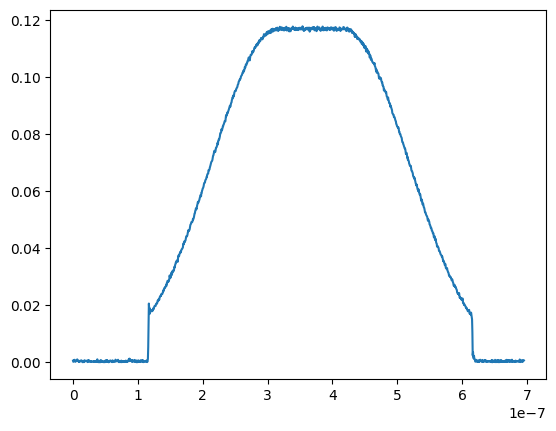

In [16]:
t = time_domain_data['time']
signal = time_domain_data['normalized_signal']
plt.plot(t, np.abs(signal))
plt.show()

In [17]:
# read spectrum data from saved file 
datafolder_today = get_datafolder_today(database_folder)
spectrum_data = read_from_csv(get_path('.csv', start_folder=datafolder_today))
print(spectrum_data.keys())

dict_keys(['freq', 'normalized_signal', 'comments'])


In [18]:
spectrum_data['comments']

['input: -15 dbm', 'output: -15 dbm', 'gain: 0.7']

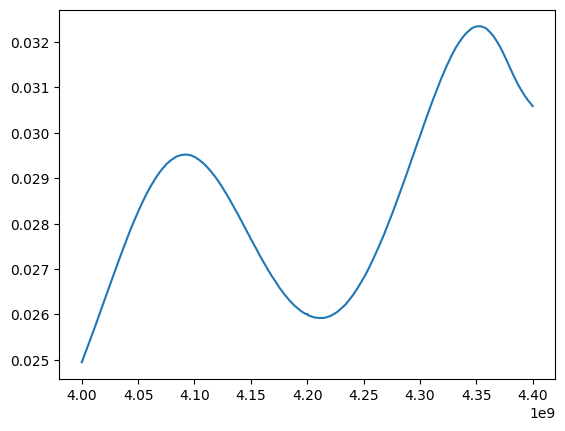

In [19]:
freq = spectrum_data['freq']
signal = spectrum_data['normalized_signal']
plt.plot(freq, np.abs(signal))
plt.show()